1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy import optimize
from scipy import fftpack
from scipy.signal import find_peaks
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
from scipy.ndimage import convolve, gaussian_filter

In [2]:
plt.rc('font', family='serif', size=8)
plt.rc('text', usetex=False)
plt.rc('mathtext', fontset='cm')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', titlesize=20)
plt.rc('figure', titlesize=15)

In [3]:
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

In [4]:
sorted_max_speeds = np.sort(max_speeds)
cprob = np.arange(1, years_nb+1, dtype=np.float32)/(years_nb + 1)
quantile_func = UnivariateSpline(cprob, sorted_max_speeds)
nprob = np.linspace(0, 1, 100)
fitted_max_speeds = quantile_func(nprob)

In [5]:
fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)

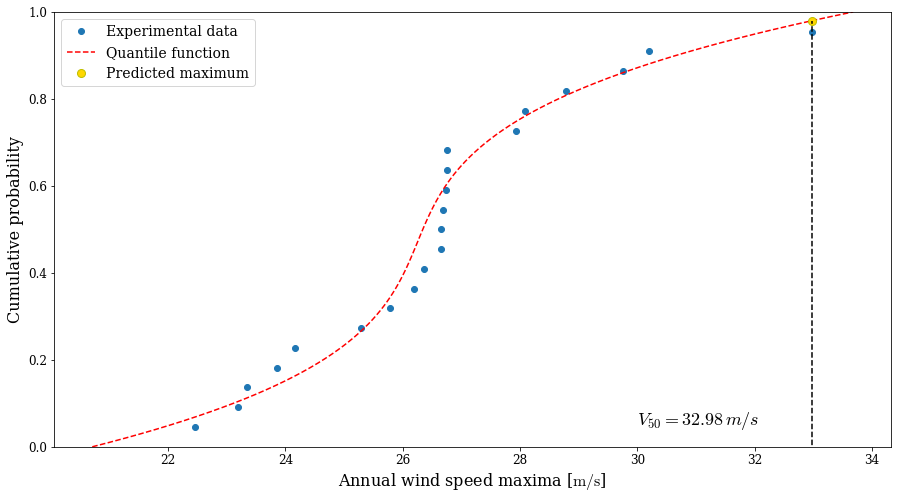

In [6]:
plt.figure(figsize=(15, 8))
plt.plot(sorted_max_speeds, cprob, 'o', label = 'Experimental data')
plt.plot(fitted_max_speeds, nprob, 'r--', label = 'Quantile function')
plt.plot([fifty_wind], [fifty_prob], 'o', ms=8., mfc='gold', mec='y', label = 'Predicted maximum')
plt.text(30, 0.05, '$V_{50} = %.2f \, m/s$' % fifty_wind, fontsize = 18)
plt.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], 'k--')
plt.xlabel(r'Annual wind speed maxima [$\mathrm{m}/\mathrm{s}$]', size=16)
plt.ylabel(r'Cumulative probability', size=16)
plt.ylim([0,1.])
plt.legend(prop={'size': 14}, loc = 'upper left')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

In [7]:
temp_max = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
temp_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.arange(1, 13)
days = np.linspace(1, 13, num = 365)

Best curve taken from [here](http://scipy-lectures.org/intro/scipy/auto_examples/solutions/plot_curvefit_temperature_data.html). This definition makes sense: with the argument of the cosine function set to $2\pi/12$, one obtains a function with period $T = 12 \ [\mathrm{months}]$. The *time_offset* serves as $x_0$ horizontal offset while *avg* represents a $y_0$ vertical offset.

In [8]:
def yearly_temps(times, avg, ampl, time_offset):
    return (avg + ampl * np.cos((times + time_offset) * 2 * np.pi / times.max()))

res_max, cov_max = optimize.curve_fit(yearly_temps, months, temp_max, p0 = [20, 10, 0])
res_min, cov_min = optimize.curve_fit(yearly_temps, months, temp_min, p0 = [-60, 25, 0])

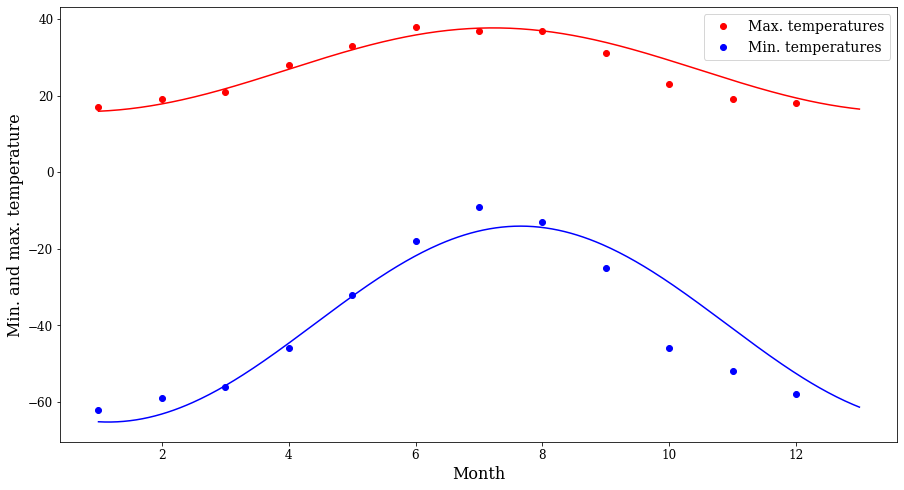

In [9]:
plt.figure(figsize=(15, 8))
plt.plot(months, temp_max, 'ro', label = 'Max. temperatures')
plt.plot(months, temp_min, 'bo', label = 'Min. temperatures')
plt.plot(days, yearly_temps(days, *res_max), 'r-')
plt.plot(days, yearly_temps(days, *res_min), 'b-')
plt.xlabel('Month', size=16)
plt.ylabel('Min. and max. temperature', size=16)
plt.legend(prop={'size': 14}, loc = 'best')

In [10]:
print("The time offset for temperatures are for max = {:.3} (red curve) and for min = {:.5} (blue curve).".format(res_max[2], res_min[2]))

The time offset for temperatures are for max = -0.723 (red curve) and for min = -1.156 (blue curve).


The time offset corresponds to $\sim8$ days for the max. temperatures and $\sim5$ days for min. temperatures with a corresponding total of $\Delta_{off} \sim13$ days. Both curves peak in July/August, while the experimental data for the max. temp. peak in June and the experimental data for the min. temp. peak in July.

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


In [11]:
def sixhump(x): #x[0] = x, x[1] = y
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3.) * x[0]**2 + x[0] * x[1] + (-4 + 4*x[1]**2) * x[1]**2)

step = int(1e3)
x = np.linspace(-2, 2, step) #variables can be restricted to −2<x<2 and −1<y<1 .
y = np.linspace(-1, 1, step)
xg, yg = np.meshgrid(x, y)

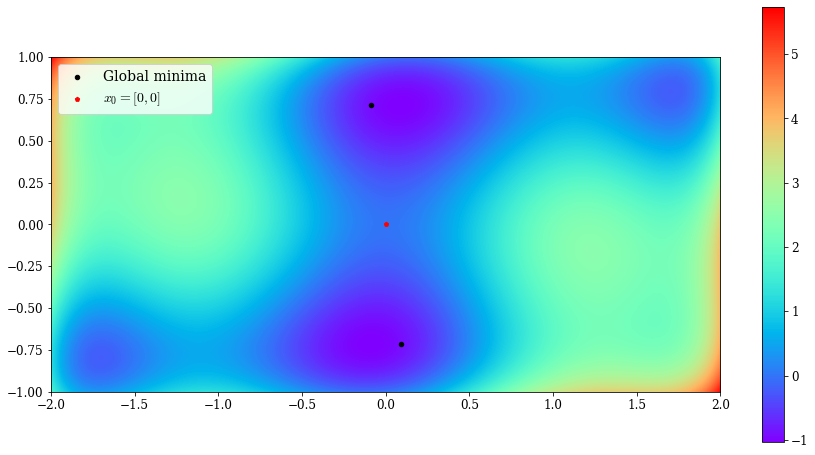

In [12]:
x_min1 = optimize.minimize(sixhump, x0=[0, 0.7]) #x0 initial guess
x_min2 = optimize.minimize(sixhump, x0=[0, -0.7])
x_min0 = optimize.minimize(sixhump, x0=[0, 0])

plt.figure(figsize=(15, 8)) #final plot
plt.imshow(sixhump([xg, yg]), extent=[-2, 2, -1, 1], cmap = 'rainbow')
plt.colorbar()
plt.scatter(x_min1.x[0], x_min1.x[1], s = 20, c = 'k', marker = 'o', label = 'Global minima')
plt.scatter(x_min2.x[0], x_min2.x[1], s = 20, c = 'k', marker = 'o')
plt.scatter(x_min0.x[0], x_min0.x[1], s = 20, c = 'r', marker = 'p', label = r'$x_0 = [0, 0]$')
plt.legend(prop={'size': 14}, loc = 'upper left')
plt.show()

In [13]:
print("There are 2 global minima and the function value at those points is {:.5} for both.".format(sixhump(x_min1.x)))

There are 2 global minima and the function value at those points is -1.0316 for both.


For an initial guess of $x_0 = [0, 0]$ the algorithm gets stuck in a local minima with value $f(x, y) = 0$.

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

In [14]:
data = np.loadtxt("populations.txt").astype(float)
year, hares, lynxes = data[:,0], data[:,1], data[:,2]

In [15]:
ly_fft, ha_fft = fftpack.fft(lynxes), fftpack.fft(hares)
ly_power, ha_power = np.abs(ly_fft), np.abs(ha_fft)
ly_freq, ha_freq = np.fft.fftfreq(ly_fft.size), np.fft.fftfreq(ha_fft.size) #default is d = 1.0 year
ly_freq, ha_freq = ly_freq[np.where(ly_freq != 0)], ha_freq[np.where(ha_freq != 0)]
ly_period, ha_period = 1 / ly_freq[ly_power.argmax()], 1 / ha_freq[ha_power.argmax()]

In [16]:
def period_ly(times, avg, ampl, time_offset):
    return (avg + ampl * np.cos((times + time_offset) * 4 * np.pi / ly_period))
def period_ha(times, avg, ampl, time_offset):
    return (avg + ampl * np.cos((times + time_offset) * 4 * np.pi / ha_period))
day = np.linspace(1900, 1920, num = 365)

In [17]:
params_ly, cov_params_ly = optimize.curve_fit(period_ly, year, lynxes, p0 = [30000, 25000, 0])
params_ha, cov_params_ha = optimize.curve_fit(period_ha, year, hares, p0 = [30000, 25000, 0])

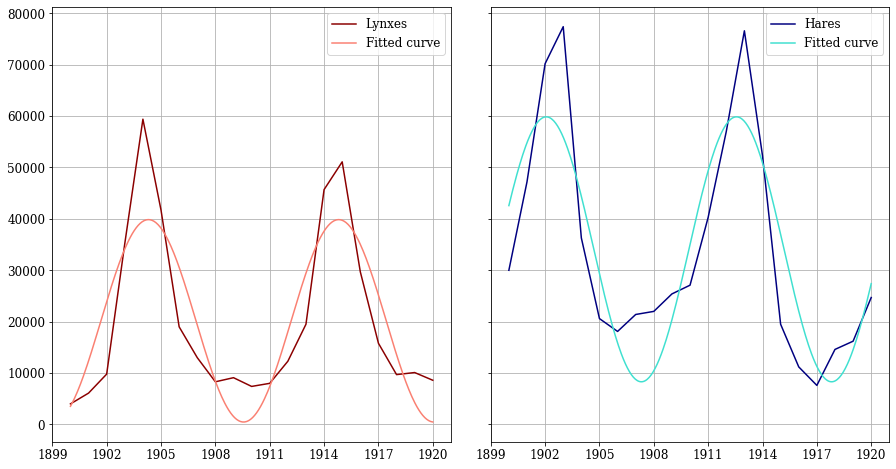

The period for both the lynxes and the hares population is 10.5 years.


In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout=False, figsize=(15, 8), sharey=True)
fig.subplots_adjust(wspace=0.1)
ax0, ax1 = axes.flatten()
ax0.plot(year, lynxes, label="Lynxes", color="darkred")
ax1.plot(year, hares, label="Hares", color="navy")
ax0.plot(day, period_ly(day, *params_ly), 'salmon', label = 'Fitted curve')
ax1.plot(day, period_ha(day, *params_ha), 'turquoise', label = 'Fitted curve')
ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax0.legend(prop={'size': 12}, loc = 'best')
ax1.legend(prop={'size': 12}, loc = 'best')
ax0.grid()
ax1.grid()

plt.show()

print('The period for both the lynxes and the hares population is {} years.'.format(ly_period*0.5))

The fitted curve in both graphs is obtained by fixing the period (embedded in $\omega$) and finding the best parameters $A$, $x_0$, $y_0$ s.t. $y = y_0 + A\cos((x+x_0)\omega)$, with the sole purpose of seeing if the data points indeed overlap with the obtained frequency.<br>
A visual proof is given by the fact that the period of the experimental data and the one of the fitted curve coincide.

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

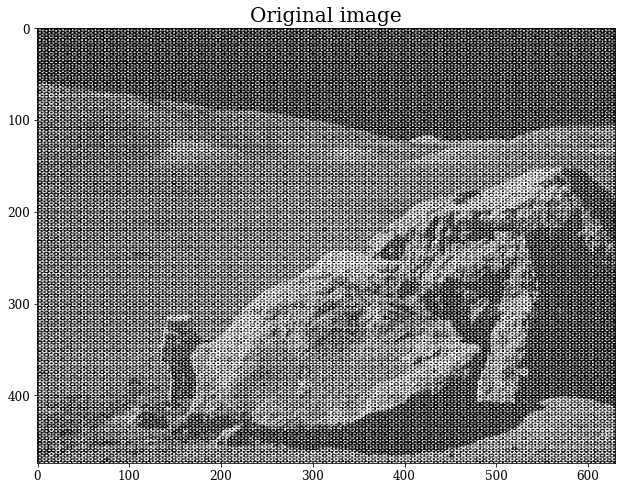

In [19]:
image = plt.imread('moonlanding.png').astype(float)

plt.figure(figsize=(15, 8))
plt.imshow(image, plt.cm.gray)
plt.title('Original image')
plt.show()

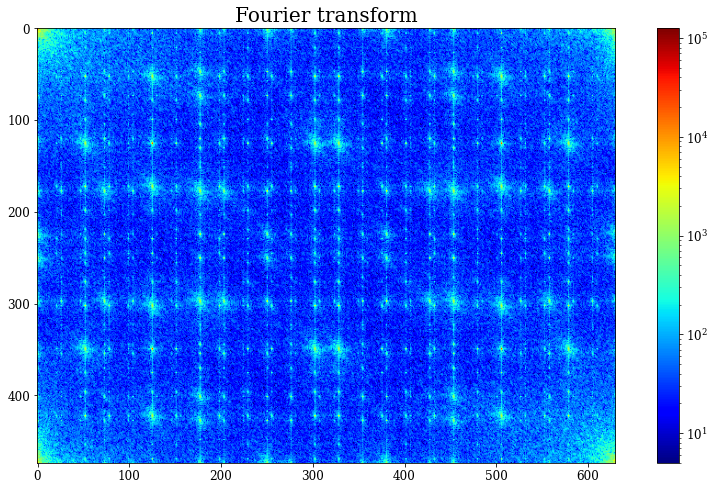

In [20]:
image_fft = fftpack.fft2(image)

plt.figure(figsize=(15, 8))
plt.imshow(np.abs(image_fft), norm=LogNorm(vmin=5), cmap = 'jet')
plt.colorbar()
plt.title('Fourier transform')
plt.show()

A logarithmic colormap is here needed since otherwise all values would have been "squeezed" in the $[0, 10^5]$ interval, resulting in a monochromatic $2D$-colorplot.

In [21]:
cutoff_freq = 2500 #set here frequency threshold
copy = image_fft.copy()
copy = np.where(np.abs(copy) > cutoff_freq, 0, copy)

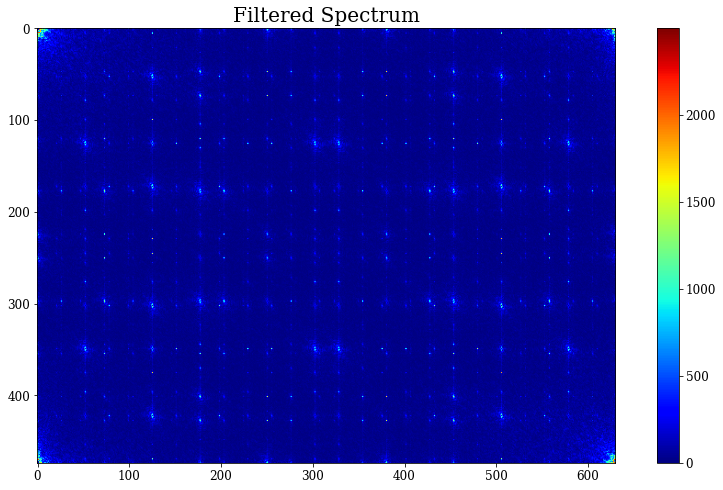

In [22]:
plt.figure(figsize=(15, 8))
plt.imshow(np.abs(copy), cmap = 'jet')
plt.colorbar()
plt.title('Filtered Spectrum')
plt.show()

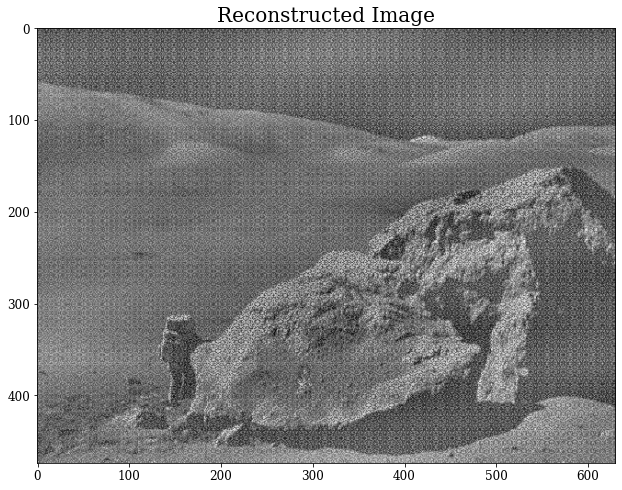

In [23]:
reconstructed = fftpack.ifft2(copy).real

plt.figure(figsize=(15, 8))
plt.imshow(reconstructed, plt.cm.gray)
plt.title('Reconstructed Image')
plt.show()

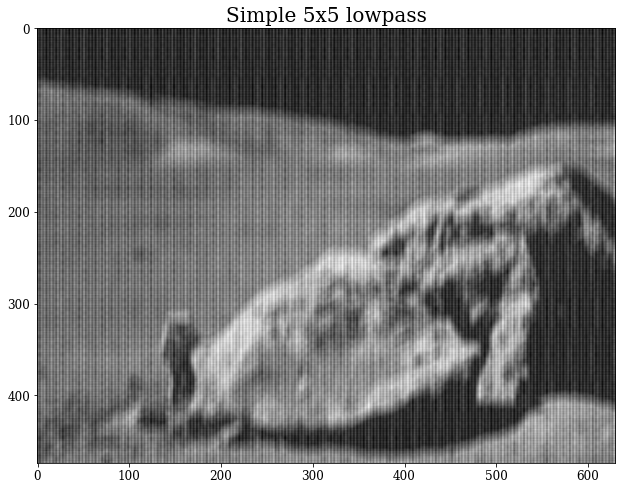

In [24]:
kernel = 3*([[1/2, 1/2,  1/2,  1/2, 1/2],
             [1/2, 1/2, 1/2, 1/2, 1/2],
             [1/2, 1/2, 1/2, 1/2, 1/2],
             [1/2, 1/2, 1/2, 1/2, 1/2],
             [1/2, 1/2,  1/2,  1/2, 1/2]])
lowpass_5x5 = convolve(image, kernel)
plt.figure(figsize=(15, 8))
plt.imshow(lowpass_5x5, plt.cm.gray)
plt.title('Simple 5x5 lowpass')
plt.show()

A simple lowpass filter calculated as the convolution with a $5\times5$ smoothing mask has still some vertical noise; a better solution is provided by a gaussian filter.

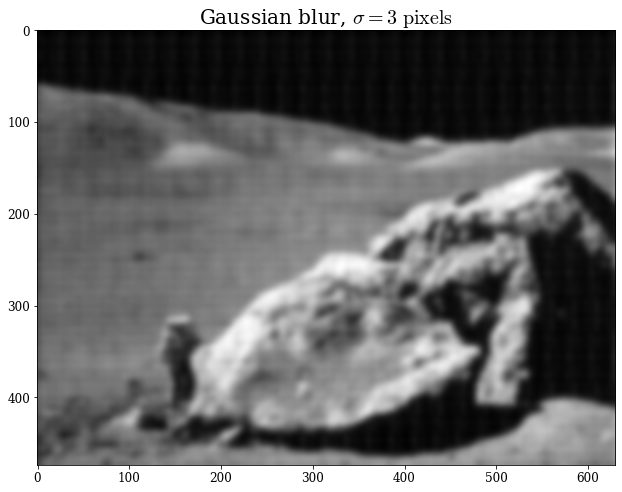

In [25]:
gaussian_blur = gaussian_filter(image, 4)

plt.figure(figsize=(15, 8))
plt.imshow(gaussian_blur, plt.cm.gray)
plt.title('Gaussian blur, $\sigma = 3 \ \mathrm{pixels}$')
plt.show()